In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## Pascal VOC

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

In [4]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [6]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [7]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [8]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [9]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal/VOC2007/Annotations'),
 PosixPath('data/pascal/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOC2007/SegmentationClass')]

In [10]:
JPEGS = 'VOC2007/JPEGImages'

In [11]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]
len(list(IMG_PATH.iterdir()))

[PosixPath('data/pascal/VOC2007/JPEGImages/008512.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/005968.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/009780.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/003524.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/008095.jpg')]

5011

In [12]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [13]:
len(trn_j[IMAGES])
len(trn_j[ANNOTATIONS])

2501

7844

In [14]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

In [15]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1]) 
        # trn_j[ANNO] x,y,w,h to trn_anno y1,x1,y2,x2 (upper left, lower right)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [16]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [17]:
trn_j[ANNOTATIONS][0][BBOX]

[155, 96, 196, 174]

In [18]:
im0_a = trn_anno[im0_d[ID]][0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [19]:
cats[7]

'car'

In [20]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [21]:
??open_image

In [22]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [23]:
im.shape

(333, 500, 3)

In [24]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [25]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [26]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [27]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

img shape: (333, 500, 3)


array([ 96, 155, 269, 350])

array([155,  96, 195, 173])

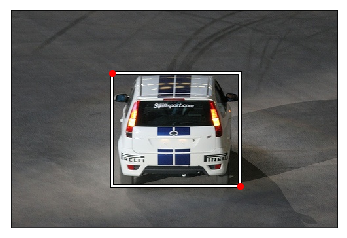

In [57]:
ax = show_img(im)
b = bb_hw(im0_a[0])
print(f'img shape: {im.shape}')
im0_a[0] # y1 x1 y2 x2
b # x1,y1,w,h
draw_rect(ax, b)
plt.plot([im0_a[0][1], im0_a[0][3]],[im0_a[0][0], im0_a[0][2]],'ro')

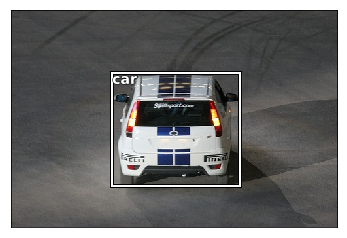

In [46]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])


In [30]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [31]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

In [32]:
trn_anno[17]
cats[15]
cats[13]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

'person'

'horse'

(364, 480, 3)


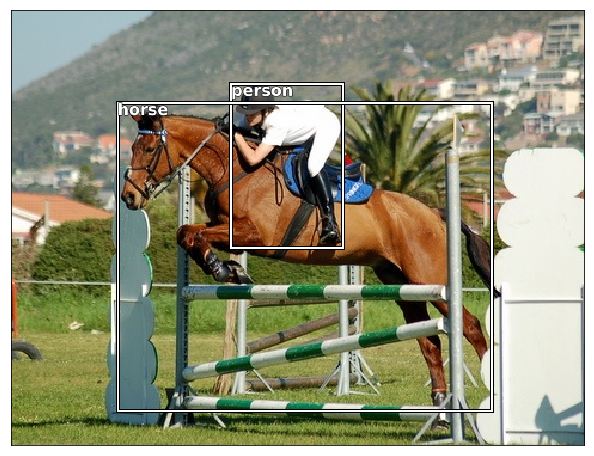

In [33]:
draw_idx(17)

## Largest item classifier

In [34]:
# get largest bbox for each pic
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [35]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [36]:
temp=17
trn_anno[temp]
trn_lrg_anno[temp]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

(array([ 77,  89, 335, 402]), 13)

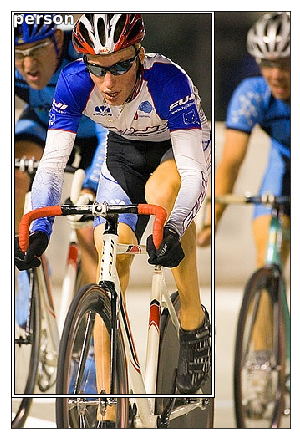

In [37]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [38]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [39]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [40]:
df.head()

,fn,cat
0,000012.jpg,car
1,000017.jpg,horse
2,000023.jpg,person
3,000026.jpg,car
4,000032.jpg,aeroplane


In [41]:
f_model = resnet34
sz=224
bs=64

In [42]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms) # random .2 of dataset will be in validation set

In [43]:
JPEGS
CSV

'VOC2007/JPEGImages'

PosixPath('data/pascal/tmp/lrg.csv')

In [50]:
??to_np

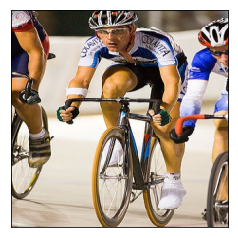

In [52]:
x,y=next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [51]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [36]:
lrf=learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:06<00:01,  3.75it/s, loss=12.4]


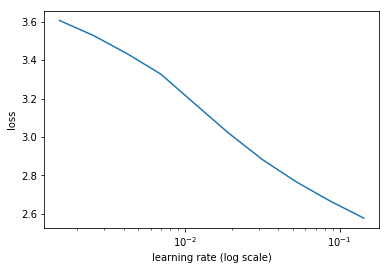

In [37]:
learn.sched.plot()

In [38]:
lr = 3e-2

In [39]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.40627    0.703061   0.809345  



[0.7030612, 0.8093449547886848]

In [40]:
lrs = np.array([lr/1000,lr/100,lr])

In [41]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:09<00:01,  2.96it/s, loss=5.03] 


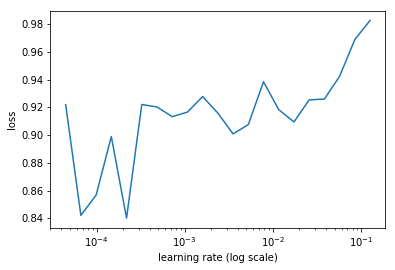

In [42]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [43]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.889958   0.601954   0.82497   



[0.601954, 0.8249699547886848]

In [44]:
learn.unfreeze()

In [45]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.640252   0.618005   0.806941  
    1      0.459939   0.593982   0.825421                  



[0.59398234, 0.8254206702113152]

## Bbox only: Predicting bbox coordinate (x1,y1) and (x2,y2)

In [53]:
BB_CSV = PATH/'tmp/bb.csv'

In [54]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [56]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,77 89 335 402
2,000023.jpg,1 2 461 242
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374


In [60]:
f_model=resnet34
sz=224
bs=64

In [58]:
# tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD) #Error: bbox value out of image size
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True) #continuous: predict continuous value

In [59]:
x,y=next(iter(md.val_dl))

In [61]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 73.,   0., 198., 461.], dtype=float32)

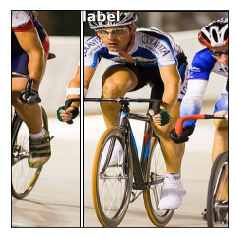

In [62]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [63]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4) #TODO: custom_head?
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [64]:
learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:05<00:01,  4.85it/s, loss=1.09e+03]


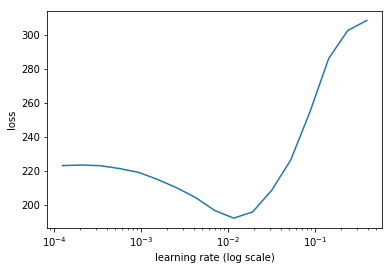

In [65]:
learn.sched.plot(5) 

In [66]:
lr = 1e-3

In [67]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      110.460948 75.463242 
    1      84.472352  66.972267                           
    2      73.9696    65.917343                           



[65.91734]

In [68]:
lrs = np.array([lr/100,lr/10,lr])

In [69]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      123.572131 24047372992512.0



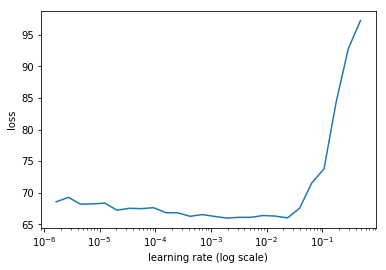

In [70]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [71]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      60.026523  56.76712  
    1      52.712649  52.410847                           
    2      45.065782  50.652924                           



[50.652924]

In [72]:
learn.freeze_to(-3)

In [73]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      38.252255  49.602478 
    1      33.058619  48.841164                           



[48.841164]

In [74]:
learn.save('reg4')

In [75]:
learn.load('reg4')

In [76]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [77]:
y

array([[ 23.83003,  46.40545, 413.41238, 348.93588],
       [150.57436,  99.68382, 347.93402, 412.0951 ],
       [ 58.30191,  37.85612, 402.13132, 372.39294],
       ...,
       [224.87096, 163.3842 , 289.64044, 259.6183 ],
       [ 86.2221 , 110.81104, 336.11908, 318.30746],
       [ 28.55247,  25.84818, 398.566  , 421.57306]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


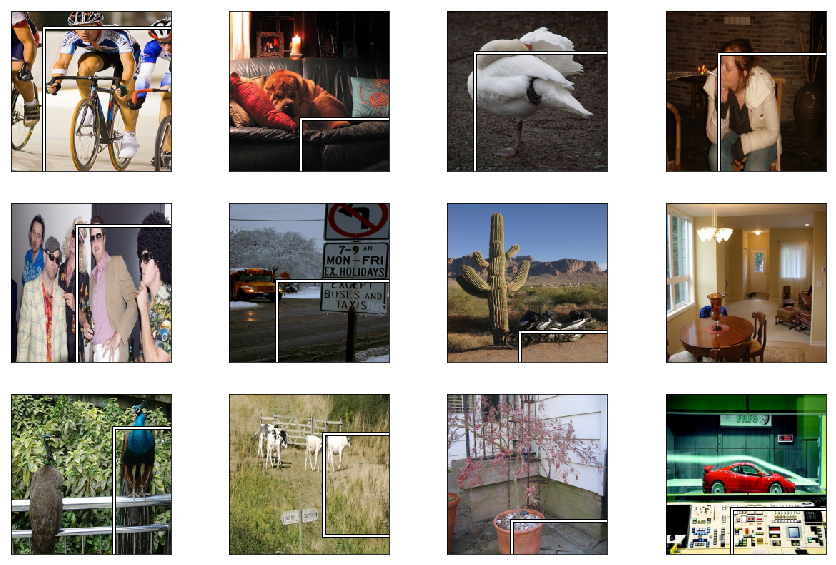

In [78]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(y[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)

## Single object detection

In [80]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [79]:
BB_CSV

PosixPath('data/pascal/tmp/bb.csv')

In [86]:
# tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, num_workers=4, val_idxs=val_idxs)

In [87]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [88]:
class ConcatLblDataset(Dataset): #TODO ???
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [89]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [90]:
x,y=next(iter(md.val_dl))

In [91]:
ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([  1., 112., 498., 288.], dtype=float32)

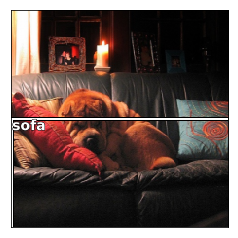

In [92]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

In [ ]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [ ]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=1e-2

In [ ]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

In [ ]:
learn.save('reg1_0')

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrs = np.array([lr/100, lr/10, lr])

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

In [ ]:
learn.save('reg1_1')

In [ ]:
learn.load('reg1_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs/5, 1, cycle_len=10, use_clr=(32,10))

In [ ]:
learn.save('reg1')

In [ ]:
learn.load('reg1')

In [ ]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [ ]:
from scipy.special import expit

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])

## End